# **EDA (Exploratory Data Analysis)**

#### **Author:** Connell Phillipps

This notebook will be the first look at the data. Here we will look the through the data distributions and follow any threads we see in the intial look at the data. This will be the notebook that begins to tell the story the data has to tell.

In [1]:
#Initializing Libraries
#Data Science Foundation
import numpy as np
import pandas as pd

#Plotting
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

#Stats
from statsmodels.graphics.tsaplots import month_plot

In [2]:
# Importing the cleaned dataset to df (with predefined datatypes)
dtypes = {
    'CAD_EVNT_ID': 'int64',
    'NYPD_PCT_CD': 'int64',
    'BORO_NM': 'category',
    'RADIO_CODE': 'category',
    'CIP_JOBS': 'category',
    'Latitude': 'float64',
    'Longitude': 'float64'
}
df = pd.read_csv(r"C:\Users\cmphi\Documents\BrainStation\DataBases\capstone_911\cleaned_df.csv", dtype=dtypes, parse_dates=['ADD_TS'])


response_df = pd.read_csv(r"C:\Users\cmphi\Documents\BrainStation\DataBases\capstone_911\cleaned_response_df.csv", dtype=dtypes, parse_dates=['DISP_TS', 'ARRIVD_TS'])

In [3]:
# List of categorical columns to plot
category_columns = ['NYPD_PCT_CD', 'BORO_NM', 'RADIO_CODE', 'CIP_JOBS']

# Calculate average response time for each category
avg_response_times = {col: response_df.groupby(col)['RESPONSE_TIME'].mean().reset_index() for col in category_columns}

C:\Users\cmphi\AppData\Local\Temp\ipykernel_5696\63960503.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_response_times = {col: response_df.groupby(col)['RESPONSE_TIME'].mean().reset_index() for col in category_columns}
C:\Users\cmphi\AppData\Local\Temp\ipykernel_5696\63960503.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_response_times = {col: response_df.groupby(col)['RESPONSE_TIME'].mean().reset_index() for col in category_columns}
C:\Users\cmphi\AppData\Local\Temp\ipykernel_5696\63960503.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a fu

## **Data Exploration:**
Now that the data is clean I will take a closer look at each column and the distribution of the values. Then we will create some visually to explore some of the findings even deeper to start to being to create a story based on the data.

In [4]:
print(df['ADD_TS'].max())
print(df['ADD_TS'].min())

2024-03-31 23:59:56
2018-01-01 00:00:07


#### **Categorical Data Distribitions:**

Plot created with help from chatGPT:<br>
Summary of prompt:<br>
Create a subplot of bar charts using plotly express to show categroical distribuitions using this code style:<br>
I then input the code from EDA notebook that had the for loop on enumerate cat_col. Smaller prompts were then asked to help refine the format till the desired end product.

In [5]:
#Plotting categorical columns
fig = make_subplots(rows=4, cols=1, subplot_titles=category_columns, vertical_spacing=.05)

for i, col in enumerate(category_columns):
    # row = (i // 2) + 1 #--- had a 2x2 wanted to change, though code was cool so kept it
    # col_pos = (i % 2) + 1
    row = i+1
    trace = go.Bar(x=df[col].unique(), y=df[col].value_counts(), name=col)
    fig.add_trace(trace, row=row, col=1) #col=col_pos
    fig.update_yaxes(title_text='Total Number of Calls')
    #Setting log scale to make graphs more ledgable...
    if i == 2 or 3:
      fig.update_yaxes(type="log", row=row, col=1)

fig.update_xaxes(matches='x')
fig.update_layout(
    title_text='Category Plots',
    width=1700,
    height=2000,
    margin=dict(l=15, r=10, t=50, b=10)
)
fig.show()

##### Insights:
* With the first distribution we are looking at total call volume by NYPD precinct. NYC precincts are differentiated by number, the graph above is then plotting those on a numeric x axis. Any number missing a bar doesn't have a correlating precinct. However, from this chart we can decently see a difference in volume. Precinct 22 has the lowest call volume with ~46,000, this precinct belongs to the central park precinct. This would make sense as there are no resident of central park so by people living in the area is close to zero. The precinct with the highest call volume is 78, located in the park slope region of brooklyn, this makes sense as when we look at call volume by burrow brooklyn has the highest volume.
* With the next distribution we are looking at call distribution by burrow. As reflected above, we see that the bronx has the highest call volume. To assure that this is not due to a larger population I referred to a [NYC population map](https://www.citypopulation.de/en/usa/newyorkcity/). The burrow with the largest population is brooklyn. This then correlates as brooklyn has the highest call volume. While Staten island has less calls by a factor of 12 and only a population 7 times smaller then that of Brooklyn suggesting that it may have a higher call rate per person.
* The next graph looks at the distribution of calls broken down by radio code, an event identifier. This graph had to be put on a log scale for visibility as there is a large discrepancy between the most frequent and least frequent call event types. Using a [radio code interpretation website](https://www.n2nov.net/nypdcodes.html) The two event types with the highest frequency are dispute(dispute) and vehicle accident, then relatively closely followed by assault(knife). There are then many radio codes that came up only once or twice its not worth diving into all of them but they involve things like mostly due to operational codes like research(disabled vehicle).
* Finally we see a breakdown of crime in progress. Again this graph was placed on a log scale to get a better view of the column breakdowns. The vast majority of calls are not in progress crimes (~38M). While the highest flag (serious) has a low volume of calls (~458,000).

#### **Distribution by datetime:**
There aren't really any numerical values to represent here so I thought it would be good to look at the call distribution by datetime.
* how many calls by month
* how many calls by day of week
* how many call within each hour of day

Plot created with help from chatGPT:<br>
Summary of prompt:<br>
Using format of the subplot create above, create a distribution based on a datetime column broken down by year, month, day of week, and hour of day. I then modified and added correct dataframe name and column names. I had to ask to sort based on calnder order.

In [6]:
fig = make_subplots(
    rows=4, cols=1, 
    subplot_titles=("Year", "Month", "Day of Week", "Hour of Day"), 
    vertical_spacing=0.05
)

# Plotting for each datetime component
datetime_components = ['Year', 'Month', 'Day of Week', 'Hour of Day']
for i, col in enumerate(datetime_components):
    row = i + 1
    if col == 'Month':
        # Order months correctly
        month_order = ["January", "February", "March", "April", "May", "June", 
                       "July", "August", "September", "October", "November", "December"]
        value_counts = df['ADD_TS'].dt.month_name().value_counts().reindex(month_order)
        trace = go.Bar(x=value_counts.index, y=value_counts.values, name=col)
    elif col == 'Day of Week':
        # Order days of the week correctly
        day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
        value_counts = df['ADD_TS'].dt.day_name().value_counts().reindex(day_order)
        trace = go.Bar(x=value_counts.index, y=value_counts.values, name=col)
    elif col == 'Hour of Day':
        value_counts = df['ADD_TS'].dt.hour.value_counts().sort_index()
        trace = go.Bar(x=value_counts.index, y=value_counts.values, name=col)
    else:
        value_counts = df['ADD_TS'].dt.year.value_counts().sort_index()
        trace = go.Bar(x=value_counts.index, y=value_counts.values, name=col)
    fig.add_trace(trace, row=row, col=1)

# Update layout to ensure independent x-axes
fig.update_layout(
    title_text='Datetime Distributions',
    width=1700,
    height=2000,
    margin=dict(l=15, r=10, t=50, b=10)
)

# Show figure
fig.show()

#### Insights:
* First, we are looking at the distribution of calls by year. I was surprised looking at this as there seems to be little effect on the call volume by year even with covid right smack in the middle of the data. There is however a rise in call volume in 2022 (relative end to the pandemic) from 6.5M calls to 7M calls.
* Next, we are looking at the call distribution by month. We notice a slightly higher call rate at the beginning of the year peaking in march at 4M calls a month on average then dropping to 3.2M for the rest of the year.
* The 3rd graph is showing call breakdown by week day. Not much to see here, during the week there seems to be very little difference between number of calls with monday being slightly less then the other weekdays. Saturday has around the same call volume as most of the weekdays with sunday again dropping slightly.
* Finally, We look at call distribution by hour of the day. Here we see 5am is the quietest time in terms of call volume, showing most people are probably asleep here. Then we see the highest peak at 4pm, this could once again be influenced by the time when most people are leaving work. Meaning more people are on the street with a higher chance for disruption and 911 calls.

#### **Distributiuon by location:**

In [7]:
'''
fig = px.density_mapbox(df, lat = 'Latitude', lon = 'Longitude',
                        radius = 6,
                        center = dict(lat = df['Latitude'].mean(), lon = df['Longitude'].mean()),
                        zoom = 8,
                        mapbox_style = 'carto-positron',
                        color_continuous_scale = 'rainbow',
                        opacity = .5)
fig.update_traces(zmin=0, zmax=100)
fig.show()
'''

"\nfig = px.density_mapbox(df, lat = 'Latitude', lon = 'Longitude',\n                        radius = 6,\n                        center = dict(lat = df['Latitude'].mean(), lon = df['Longitude'].mean()),\n                        zoom = 8,\n                        mapbox_style = 'carto-positron',\n                        color_continuous_scale = 'rainbow',\n                        opacity = .5)\nfig.update_traces(zmin=0, zmax=100)\nfig.show()\n"

Above the goal will be show the distribution by call volume. First total, then I could animate by hour and day to show how the location of call volume change through time... This is a bit out of the scope for me and sprint 1. But goal will be to get on this after sprint 1 presnetaion. Millions of rows will be to much to display at once so I will need to create lat lon groups the agrigate the data by those groups and display them. It will take some testing but for this graph I want to try to get as granular as possible wihtout crashing the computer (that is what the code above will do).

#### **Avergae response time by category**
Here I would like to see if the response time is effected by any of the catagorical columns.

In [8]:
response_df.head()

CAD_EVNT_ID  NYPD_PCT_CD    BORO_NM RADIO_CODE CIP_JOBS  \
0     43928145           78   BROOKLYN       10H1  Non CIP   
1     43928146           23  MANHATTAN       54C1  Non CIP   
2     43928152           14  MANHATTAN       22Q1  Non CIP   
3     43928158           43      BRONX       52D1  Non CIP   
4     43928161           79   BROOKLYN       34Q1  Serious   

              DISP_TS           ARRIVD_TS   Latitude  Longitude  RESPONSE_TIME  
0 2018-01-01 00:23:16 2018-01-01 00:27:37  40.667331 -73.974585       4.350000  
1 2018-01-01 00:07:21 2018-01-01 00:31:12  40.791893 -73.948484      23.850000  
2 2018-01-01 00:07:33 2018-01-01 00:46:31  40.754699 -73.993501      38.966667  
3 2018-01-01 00:14:29 2018-01-01 00:53:00  40.841443 -73.854732      38.516667  
4 2018-01-01 00:02:36 2018-01-01 00:07:10  40.688947 -73.946476       4.566667

Plot created with help from chatGPT:<br>
Summary of prompt:<br>
input code from categorical breakdown but instead of call distribtion would like to graph aveage resonse time based on two datetime columns. Again some subpromts to refine to the end prodcut that I liked below.

In [9]:
# Plotting categorical columns with average response time
fig = make_subplots(rows=len(category_columns), cols=1, subplot_titles=category_columns, vertical_spacing=.1)

for i, col in enumerate(category_columns):
    avg_data = avg_response_times[col]
    trace = go.Bar(x=avg_data[col], y=avg_data['RESPONSE_TIME'], name=col)
    fig.add_trace(trace, row=i + 1, col=1)
    fig.update_yaxes(title_text='Average Response Time (minutes)', row=i + 1, col=1)

fig.update_layout(
    title_text='Average Response Time by Category',
    width=1700,
    height=2000,
    margin=dict(l=15, r=10, t=50, b=10)
)
fig.show()

#### Insights:
* Similar to the call distrbution by category but here we are comparing average respnse time to each precinct. The precincts with the worst response times are 102, 105, 109, 113. These are all geographicly in the south queens. In queens the precint size is larger so I am sure this adds to the resonse time. [Refernce](https://www.nyc.gov/site/nypd/bureaus/patrol/find-your-precinct.page).
* Again reflected in the second graph we can see response time by burrow. With queens and the bronx having the highest reponse time. Agian as can be seen in the provied link it is probably mostly in part due to the size of the precints in those burrows. The other side of this is Manhatten which has the lowest response time, again unsipringly as the precint size in manhatten are the smallest in all of NYC so the police has less area to travel.
* Third, we are looking that the response time by radio code. With the highest 3 call response times as (65S8: 262min, 69I: 136min, 22V8: 122min) corrisponding to (Utility trouble(one officer), other noncrime insident, Larceny(vechile)). To get a better understanding of these values we would need to see how many data points corrispond to each but for now we can see non critical calls recives low prority in terms of police reponse at over 2hrs.
* Finally, we are looking at response time by crime in progess status. Gladly we see that cirtical staus has the lowest reponse time with an average reponse of 5 1/2 mins. While non crime in process calls are at around 15mins.

#### **Time Series Evalutaion**

I am now going to apply the datetime as the index, then treating the main df as a time series dateframe from here out. With the end goal to clean the data in terms of a datetime range (first by day of week and then hour of day). When I better understand the webscrapping API I hope to also take a look at yearly trends by looking at month of year.

In [10]:
df.head()

CAD_EVNT_ID  NYPD_PCT_CD    BORO_NM RADIO_CODE CIP_JOBS  \
0     43928145           78   BROOKLYN       10H1  Non CIP   
1     43928146           23  MANHATTAN       54C1  Non CIP   
2     43928150           40      BRONX       54U1  Non CIP   
3     43928152           14  MANHATTAN       22Q1  Non CIP   
4     43928154          114     QUEENS       11C4  Non CIP   

               ADD_TS   Latitude  Longitude  
0 2018-01-01 00:00:07  40.667331 -73.974585  
1 2018-01-01 00:00:21  40.791893 -73.948484  
2 2018-01-01 00:00:26  40.806898 -73.915558  
3 2018-01-01 00:00:37  40.754699 -73.993501  
4 2018-01-01 00:00:50  40.768440 -73.924675

In [11]:
#aggrigating dataframe into hourly and daily - will be monthly also when api is fixed
hourly_df = df.set_index('ADD_TS').resample('H').size().reset_index(name='num_calls').set_index('ADD_TS')
daily_df = df.set_index('ADD_TS').resample('D').size().reset_index(name='num_calls').set_index('ADD_TS')
monthly_df = df.set_index('ADD_TS').resample('M').size().reset_index(name='num_calls').set_index('ADD_TS')
yearly_df = df.set_index('ADD_TS').resample('Y').size().reset_index(name='num_calls').set_index('ADD_TS')

display(hourly_df)
display(daily_df)
display(monthly_df)
display(yearly_df)

num_calls
ADD_TS                        
2018-01-01 00:00:00        838
2018-01-01 01:00:00       1006
2018-01-01 02:00:00        928
2018-01-01 03:00:00        801
2018-01-01 04:00:00        727
...                        ...
2024-03-31 19:00:00        915
2024-03-31 20:00:00        980
2024-03-31 21:00:00        848
2024-03-31 22:00:00        828
2024-03-31 23:00:00        755

[54768 rows x 1 columns]

num_calls
ADD_TS               
2018-01-01      15189
2018-01-02      15492
2018-01-03      15992
2018-01-04      13948
2018-01-05      16099
...               ...
2024-03-27      19927
2024-03-28      18767
2024-03-29      20355
2024-03-30      18338
2024-03-31      18275

[2282 rows x 1 columns]

num_calls
ADD_TS               
2018-01-31     484828
2018-02-28     445971
2018-03-31     514345
2018-04-30     503998
2018-05-31     546483
...               ...
2023-11-30     542029
2023-12-31     547400
2024-01-31     561745
2024-02-29     552545
2024-03-31     636555

[75 rows x 1 columns]

num_calls
ADD_TS               
2018-12-31    6175109
2019-12-31    6403943
2020-12-31    6210622
2021-12-31    6493833
2022-12-31    7171033
2023-12-31    6815913
2024-12-31    1750845

In [12]:
#Hourly Plot
fig = px.line(hourly_df, x=hourly_df.index, y=hourly_df.num_calls)

# axis labels and title
fig.update_layout(
    yaxis_title="Number of Calls", 
    legend_title="", 
    title="Number of Calls by hours"
)

# activate slider
fig.update_xaxes(rangeslider_visible=True)

fig.show()

c:\Users\cmphi\anaconda3\envs\dump\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [13]:
#Daily Plot
fig = px.line(daily_df, x=daily_df.index, y=daily_df.num_calls)

# axis labels and title
fig.update_layout(
    yaxis_title="Number of Calls", 
    legend_title="", 
    title="Number of Calls by day"
)

# activate slider
fig.update_xaxes(rangeslider_visible=True)

fig.show()

c:\Users\cmphi\anaconda3\envs\dump\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [14]:
#Monthly Plot
fig = px.line(monthly_df, x=monthly_df.index, y=monthly_df.num_calls)

# axis labels and title
fig.update_layout(
    yaxis_title="Number of Calls", 
    legend_title="", 
    title="Number of Calls by month"
)

# activate slider
fig.update_xaxes(rangeslider_visible=True)

fig.show()

c:\Users\cmphi\anaconda3\envs\dump\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [15]:
#Daily Plot
fig = px.line(yearly_df, x=yearly_df.index, y=yearly_df.num_calls)

# axis labels and title
fig.update_layout(
    yaxis_title="Number of Calls", 
    legend_title="", 
    title="Number of Calls by year"
)

# activate slider
fig.update_xaxes(rangeslider_visible=True)

fig.show()

c:\Users\cmphi\anaconda3\envs\dump\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



### **Time Series EDA:**

In [16]:
print(hourly_df.shape)
print(daily_df.shape)
print(monthly_df.shape)
print(yearly_df.shape)

(54768, 1)
(2282, 1)
(75, 1)
(7, 1)


In [17]:
#Grabbing first and last time stamp from each
first_day = daily_df.index.min()
last_day = daily_df.index.max()

first_hour = hourly_df.index.min()
last_hour = hourly_df.index.max()

first_month = monthly_df.index.min()
last_month = monthly_df.index.max()

first_year = yearly_df.index.min()
last_year = yearly_df.index.max()

print(first_day, last_day)
print(first_hour, last_hour)
print(first_month, last_month)
print(first_year, last_year)

2018-01-01 00:00:00 2024-03-31 00:00:00
2018-01-01 00:00:00 2024-03-31 23:00:00
2018-01-31 00:00:00 2024-03-31 00:00:00
2018-12-31 00:00:00 2024-12-31 00:00:00


In [18]:
#Identifying missing values
daily_full_range = pd.date_range(start=first_day, end=last_day, freq="D")
print(daily_full_range.difference(daily_df.index))

hourly_full_range = pd.date_range(start=first_hour, end=last_hour, freq="H")
print(hourly_full_range.difference(hourly_df.index))

monthly_full_range = pd.date_range(start=first_month, end=last_month, freq='M')
print(monthly_full_range.difference(monthly_df.index))

yearly_full_range = pd.date_range(start=first_year, end=last_year, freq='Y')
print(yearly_full_range.difference(yearly_df.index))

DatetimeIndex([], dtype='datetime64[ns]', freq='D')
DatetimeIndex([], dtype='datetime64[ns]', freq='H')
DatetimeIndex([], dtype='datetime64[ns]', freq='M')
DatetimeIndex([], dtype='datetime64[ns]', freq='A-DEC')


In [19]:
print(daily_df.isna().sum())
print(hourly_df.isna().sum())
print(monthly_df.isna().sum())
print(yearly_df.isna().sum())

num_calls    0
dtype: int64
num_calls    0
dtype: int64
num_calls    0
dtype: int64
num_calls    0
dtype: int64


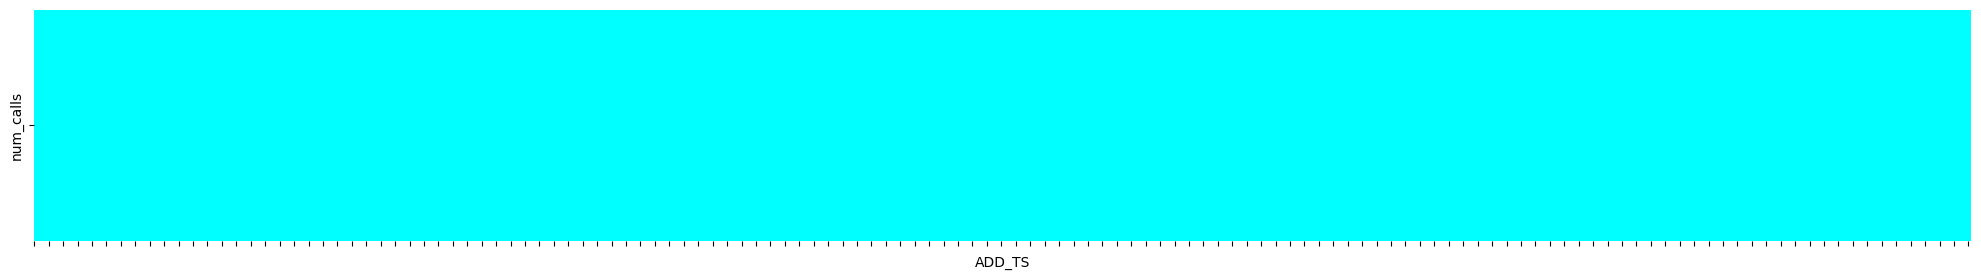

In [20]:
#Create a heatmap to illustrate missing values relative to existing indexes

plt.figure(figsize=(25,3))

ax = sns.heatmap(daily_df.isna().T, cmap='cool', cbar=False)
ax.set(xticklabels=[])

plt.show()

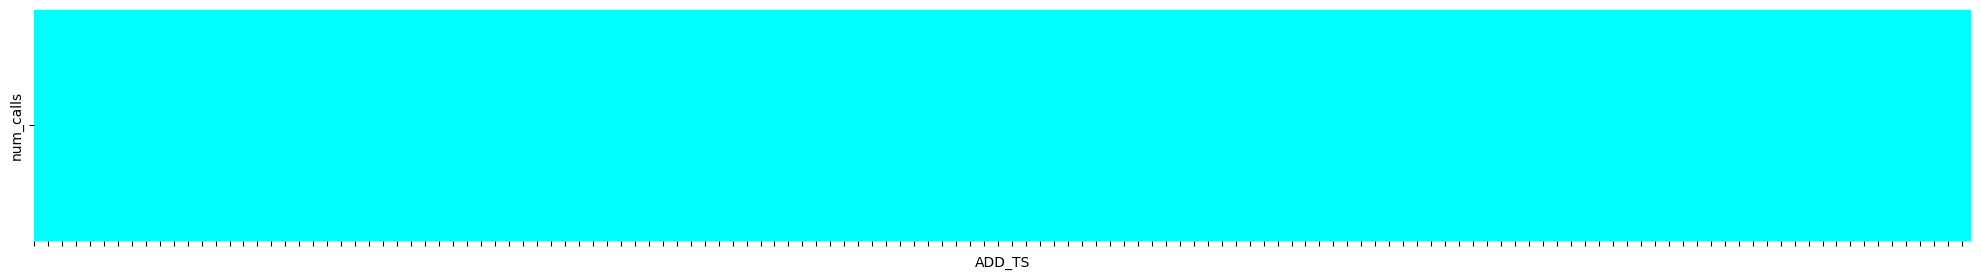

In [21]:
#Create a heatmap to illustrate missing values relative to existing indexes

plt.figure(figsize=(25,3))

ax = sns.heatmap(hourly_df.isna().T, cmap='cool', cbar=False)
ax.set(xticklabels=[])

plt.show()

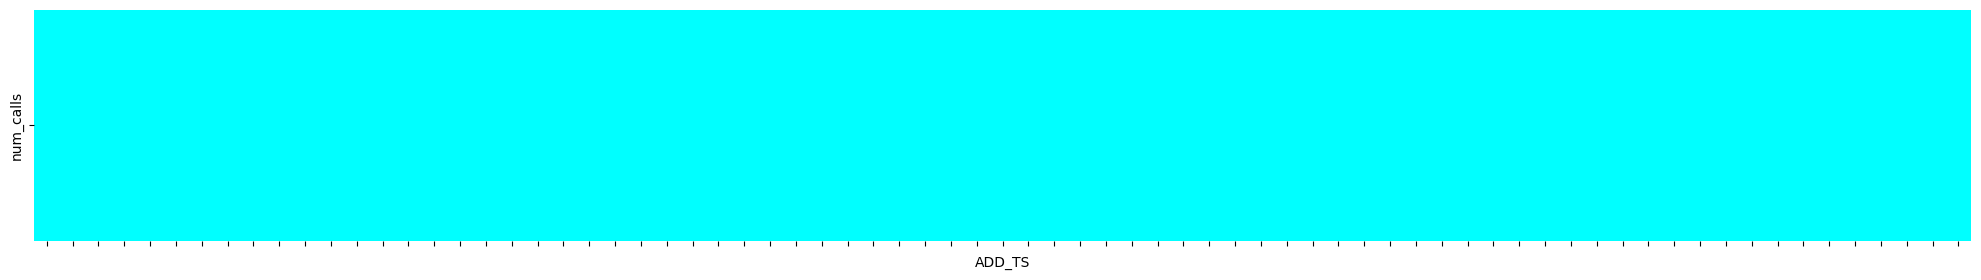

In [22]:
#Create a heatmap to illustrate missing values relative to existing indexes

plt.figure(figsize=(25,3))

ax = sns.heatmap(monthly_df.isna().T, cmap='cool', cbar=False)
ax.set(xticklabels=[])

plt.show()

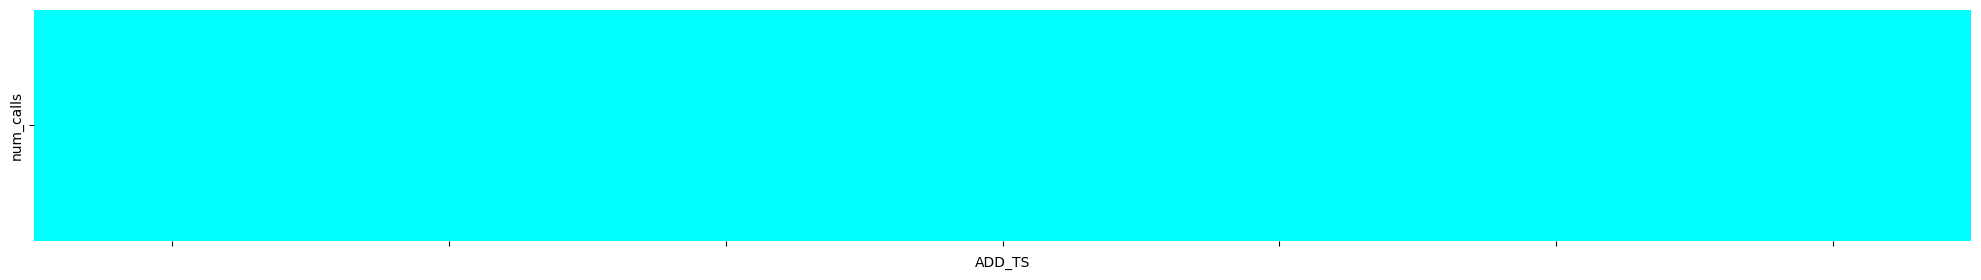

In [23]:
#Create a heatmap to illustrate missing values relative to existing indexes

plt.figure(figsize=(25,3))

ax = sns.heatmap(yearly_df.isna().T, cmap='cool', cbar=False)
ax.set(xticklabels=[])

plt.show()

This show we are not missing any data points in both the index and in rows. Good saves a step.<br><br>

Next, we will beging to look at the datas seasonality.

In [24]:
#Beginning with hourly
# Calculate the mean number of calls per hour
hourly_mean = hourly_df.mean()

# Calculate the relative deviation from the overall mean
hourly_mean_diff = (hourly_df - hourly_mean) / hourly_mean

# Extract the hour from the datetime index
hourly_mean_diff.index = hourly_mean_diff.index.hour

# Group by the hour of the day to get the average deviation for each hour
hourly_mean_diff_by_hour = hourly_mean_diff.groupby(hourly_mean_diff.index).mean()

# Convert the result to a DataFrame for plotting
hourly_mean_diff_df = hourly_mean_diff_by_hour.reset_index()
hourly_mean_diff_df.columns = ['hour', 'deviation']

#plotting
fig = px.bar(hourly_mean_diff_df, x='hour', y='deviation')

fig.update_layout(
    yaxis_title="Relative Deviation (%)", 
    yaxis_tickformat = '%',
    xaxis_title="Hour of the Day",
    showlegend=False,
    title="Hourly Deviation from Mean Number of Calls (%)"
)

fig.show()

The trend we see here is that the peak number of calls in the day are around 4pm decreasing till 5am where there is less then aveage calls per hour.

In [25]:
# daily average
daily_mean = daily_df.groupby(daily_df.index.day_name()).mean()

# relative deviation from the overall mean
daily_mean_diff = (daily_mean - daily_mean.mean())/daily_mean

# month names in right order
day_names = pd.date_range(start=first_day, freq='D', periods=7).day_name()

# reorder columns to follow the month order
daily_mean_diff = daily_mean_diff.loc[day_names, ]

daily_mean_diff.T

fig = px.bar(daily_mean_diff)

fig.update_layout(
    yaxis_title="Relative Deviation (%)", 
    yaxis_tickformat = '%',
    xaxis_title="Day of the Week",
    showlegend=False,
    title="Daily Deviation from Mean Number of Calls (%)"
)

fig.show()

Represnted in this graph we can see that again calls on friday are at a much higher rate then the average. While calls on monday and sunday are way below the average.

In [26]:
# monthly
monthly_mean = monthly_df.groupby(monthly_df.index.month_name()).mean()

# relative deviation from the overall mean
monthly_mean_diff = (monthly_mean - monthly_mean.mean())/monthly_mean

# month names in right order
month_names = pd.date_range(start=first_day, freq='M', periods=12).month_name()

# reorder columns to follow the month order
monthly_mean_diff = monthly_mean_diff.loc[month_names, ]

monthly_mean_diff.T

fig = px.bar(monthly_mean_diff)

fig.update_layout(
    yaxis_title="Relative Deviation (%)", 
    yaxis_tickformat = '%',
    xaxis_title="Month",
    showlegend=False,
    title='Monthly Deviation from Mean Number of Calls (%)'
)

fig.show()

Insites here

In [27]:
yearly_mean = yearly_df['num_calls'].mean()

# Compute the relative deviation from the overall mean
yearly_mean_diff = (yearly_df['num_calls'] - yearly_mean) / yearly_mean

# Convert the Series to DataFrame for Plotly
yearly_mean_diff_df = yearly_df.copy()
yearly_mean_diff_df['Relative Deviation'] = yearly_mean_diff.values

# Create the plot using Plotly
fig = px.bar(yearly_mean_diff_df, x='ADD_TS', y='Relative Deviation', title="Yearly Deviation from Mean Number of Calls (%)")

fig.update_layout(
    yaxis_title="Relative Deviation (%)", 
    yaxis_tickformat = '%',
    xaxis_title="Year",
    showlegend=False,
    title='Yearly Deviation from Mean Number of Calls (%)'
)

fig.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['num_calls', 'Relative Deviation'] but received: ADD_TS

insites here

In [ ]:
# \\TODO: Create same deviations plotted and for all police precincts and burrows overlayed on 
# # \\TODO: 